## Authorizing an application to access Twitter account data

In [1]:
import tweepy
import json

In [2]:
from itertools import islice

In [4]:
auth = tweepy.auth.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [5]:
print(api)

## Retrieving trends

In [6]:
# The Yahoo! Where On Earth ID for the entire world is 1.
# See https://dev.twitter.com/docs/api/1.1/get/trends/place and
# http://developer.yahoo.com/geo/geoplanet/

WORLD_WOE_ID = 1
ZH_WOE_ID = 784794

world_trends = api.trends_place(WORLD_WOE_ID)
zh_trends = api.trends_place(ZH_WOE_ID)

print(json.dumps(list(islice(world_trends[0]['trends'], 3)), indent=1))

[
 {
  "name": "#ARSMUN",
  "url": "http://twitter.com/search?q=%23ARSMUN",
  "promoted_content": null,
  "query": "%23ARSMUN",
  "tweet_volume": 197509
 },
 {
  "name": "Arsenal",
  "url": "http://twitter.com/search?q=Arsenal",
  "promoted_content": null,
  "query": "Arsenal",
  "tweet_volume": 416166
 },
 {
  "name": "#COYG",
  "url": "http://twitter.com/search?q=%23COYG",
  "promoted_content": null,
  "query": "%23COYG",
  "tweet_volume": 26454
 }
]


In [7]:
world_trends_set = set([trend['name'] 
                        for trend in world_trends[0]['trends']])

zh_trends_set = set([trend['name'] 
                     for trend in zh_trends[0]['trends']])

common_trends = world_trends_set.intersection(zh_trends_set)

print(common_trends)

{'#QatarGP', '#ARSMUN', 'Arsenal'}


## Anatomy of a Tweet

In [8]:
q = '#QatarGP' 

count = 100

# Import unquote to prevent url encoding errors in next_results
from urllib.parse import unquote

# See https://dev.twitter.com/rest/reference/get/search/tweets

search_results = api.search(q=q, count=count)

In [9]:
statuses = search_results['statuses']

In [10]:
search_results.keys()

dict_keys(['statuses', 'search_metadata'])

In [11]:
# Iterate through 5 more batches of results by following the cursor
for _ in range(5):
    print('Length of statuses', len(statuses))
    try:
        next_results = search_results['search_metadata']['next_results']
    except KeyError as e: # No more results when next_results doesn't exist
        break
        
    # Create a dictionary from next_results, which has the following form:
    # ?max_id=847960489447628799&q=%23RIPSelena&count=100&include_entities=1
    kwargs = dict([ kv.split('=') for kv in unquote(next_results[1:]).split("&") ])
    print(next_results[1:].split("&"))
    search_results = api.search(**kwargs)
    statuses += search_results['statuses']

Length of statuses 100
['max_id=1104830678968004607', 'q=%23QatarGP', 'count=100', 'include_entities=1']
Length of statuses 198
['max_id=1104829988816199686', 'q=%23QatarGP', 'count=100', 'include_entities=1']
Length of statuses 298
['max_id=1104829298719014912', 'q=%23QatarGP', 'count=100', 'include_entities=1']
Length of statuses 398
['max_id=1104828674421870592', 'q=%23QatarGP', 'count=100', 'include_entities=1']
Length of statuses 498
['max_id=1104828113341632511', 'q=%23QatarGP', 'count=100', 'include_entities=1']


In [12]:
# Show one sample search result by slicing the list...
print(json.dumps(statuses[0], indent=2))

{
  "created_at": "Sun Mar 10 19:48:23 +0000 2019",
  "id": 1104831384533626881,
  "id_str": "1104831384533626881",
  "text": "RT @MotoGP: \ud83c\udfc1 #MotoGP RACE\n\nConfirmation of the results after a stunning season opener at Losail! \u23f1\ufe0f\n\n#QatarGP \ud83c\uddf6\ud83c\udde6 https://t.co/8z0jCavYuJ",
  "truncated": false,
  "entities": {
    "hashtags": [
      {
        "text": "MotoGP",
        "indices": [
          14,
          21
        ]
      },
      {
        "text": "QatarGP",
        "indices": [
          102,
          110
        ]
      }
    ],
    "symbols": [],
    "user_mentions": [
      {
        "screen_name": "MotoGP",
        "name": "MotoGP\u2122 \ud83c\uddf6\ud83c\udde6",
        "id": 14082692,
        "id_str": "14082692",
        "indices": [
          3,
          10
        ]
      }
    ],
    "urls": [],
    "media": [
      {
        "id": 1104807142006185986,
        "id_str": "1104807142006185986",
        "indices": [
          114,
  

In [13]:
for i in range(3):
    print()
    print(statuses[i]['text'])
    print('Favorites: ', statuses[i]['favorite_count'])
    print('Retweets: ', statuses[i]['retweet_count'])


RT @MotoGP: 🏁 #MotoGP RACE

Confirmation of the results after a stunning season opener at Losail! ⏱️

#QatarGP 🇶🇦 https://t.co/8z0jCavYuJ
Favorites:  0
Retweets:  378

RT @MotoGP: First #MotoGP winner of 2019 💪

@AndreaDovizioso took another victory on the finish line at the #QatarGP 🏁 https://t.co/H94HHCz…
Favorites:  0
Retweets:  10

RT @MotoGP: “Eventually I would love to try a MotoGP bike, that’s the dream.” 💬 

5 time F1 World Champion @LewisHamilton  certainly enjoye…
Favorites:  0
Retweets:  465


## Extracting text, screen names, and hashtags from tweets

In [14]:
status_texts = [ status['text'] 
                 for status in statuses ]

screen_names = [ user_mention['screen_name'] 
                 for status in statuses
                     for user_mention in status['entities']['user_mentions'] ]

hashtags = [ hashtag['text'] 
             for status in statuses
                 for hashtag in status['entities']['hashtags'] ]

# Compute a collection of all words from all tweets
words = [ w 
          for t in status_texts 
              for w in t.split() ]

# Explore the first 5 items for each...

print(json.dumps(status_texts[0:5], indent=1))
print(json.dumps(screen_names[0:5], indent=1) )
print(json.dumps(hashtags[0:5], indent=1))
print(json.dumps(words[0:5], indent=1))

[
 "RT @MotoGP: \ud83c\udfc1 #MotoGP RACE\n\nConfirmation of the results after a stunning season opener at Losail! \u23f1\ufe0f\n\n#QatarGP \ud83c\uddf6\ud83c\udde6 https://t.co/8z0jCavYuJ",
 "RT @MotoGP: First #MotoGP winner of 2019 \ud83d\udcaa\n\n@AndreaDovizioso took another victory on the finish line at the #QatarGP \ud83c\udfc1 https://t.co/H94HHCz\u2026",
 "RT @MotoGP: \u201cEventually I would love to try a MotoGP bike, that\u2019s the dream.\u201d \ud83d\udcac \n\n5 time F1 World Champion @LewisHamilton  certainly enjoye\u2026",
 "RT @MotoGP: First #MotoGP winner of 2019 \ud83d\udcaa\n\n@AndreaDovizioso took another victory on the finish line at the #QatarGP \ud83c\udfc1 https://t.co/H94HHCz\u2026",
 "RT @MotoGP: Spot the difference \ud83d\ude09\n\n#QatarGP \ud83c\uddf6\ud83c\udde6 https://t.co/Uw0BrS6yrL"
]
[
 "MotoGP",
 "MotoGP",
 "AndreaDovizioso",
 "MotoGP",
 "LewisHamilton"
]
[
 "MotoGP",
 "QatarGP",
 "MotoGP",
 "QatarGP",
 "MotoGP"
]
[
 "RT",
 "@MotoGP:",
 "\ud83c\udfc1",

## Creating a basic frequency distribution from the words in tweets

In [15]:
from collections import Counter

for item in [words, screen_names, hashtags]:
    c = Counter(item)
    print(c.most_common()[:10]) # top 10
    print()

[('RT', 513), ('#QatarGP', 471), ('the', 352), ('@MotoGP:', 268), ('🇶🇦', 233), ('#MotoGP', 140), ('of', 114), ('a', 114), ('to', 112), ('in', 109)]

[('MotoGP', 295), ('AndreaDovizioso', 112), ('marcmarquez93', 78), ('ValeYellow46', 59), ('btsportmotogp', 23), ('LewisHamilton', 21), ('YamahaMotoGP', 19), ('DucatiMotor', 17), ('KaitoToba', 15), ('calcrutchlow', 14)]

[('QatarGP', 486), ('MotoGP', 155), ('MM93', 16), ('MonsterYamaha', 16), ('SkyMotori', 15), ('Dovizioso', 13), ('MotoGP_jp', 12), ('Moto2', 12), ('Moto3', 12), ('ForzaDucati', 12)]



## Using prettytable to display tuples in a nice tabular format

In [16]:
from prettytable import PrettyTable

for label, data in (('Word', words), 
                    ('Screen Name', screen_names), 
                    ('Hashtag', hashtags)):
    pt = PrettyTable(field_names=[label, 'Count']) 
    c = Counter(data)
    [ pt.add_row(kv) for kv in c.most_common()[:10] ]
    pt.align[label], pt.align['Count'] = 'l', 'r' # Set column alignment
    print(pt)

+----------+-------+
| Word     | Count |
+----------+-------+
| RT       |   513 |
| #QatarGP |   471 |
| the      |   352 |
| @MotoGP: |   268 |
| 🇶🇦       |   233 |
| #MotoGP  |   140 |
| of       |   114 |
| a        |   114 |
| to       |   112 |
| in       |   109 |
+----------+-------+
+-----------------+-------+
| Screen Name     | Count |
+-----------------+-------+
| MotoGP          |   295 |
| AndreaDovizioso |   112 |
| marcmarquez93   |    78 |
| ValeYellow46    |    59 |
| btsportmotogp   |    23 |
| LewisHamilton   |    21 |
| YamahaMotoGP    |    19 |
| DucatiMotor     |    17 |
| KaitoToba       |    15 |
| calcrutchlow    |    14 |
+-----------------+-------+
+---------------+-------+
| Hashtag       | Count |
+---------------+-------+
| QatarGP       |   486 |
| MotoGP        |   155 |
| MM93          |    16 |
| MonsterYamaha |    16 |
| SkyMotori     |    15 |
| Dovizioso     |    13 |
| MotoGP_jp     |    12 |
| Moto2         |    12 |
| Moto3         |    12 |
| 

## Calculating lexical diversity for tweets

In [17]:
# A function for computing lexical diversity
def lexical_diversity(tokens):
    return len(set(tokens))/len(tokens) 

# A function for computing the average number of words per tweet
def average_words(statuses):
    total_words = sum([ len(s.split()) for s in statuses ]) 
    return total_words/len(statuses)

print(lexical_diversity(words))
print(lexical_diversity(screen_names))
print(lexical_diversity(hashtags))
print(average_words(status_texts))

0.2236764416453454
0.14948453608247422
0.11267605633802817
16.993311036789297


## Finding the most popular retweets

In [18]:
retweets = [
            # Store out a tuple of these three values ...
            (status['retweet_count'], 
             status['retweeted_status']['user']['screen_name'],
             status['retweeted_status']['id'],
             status['text']) 
            
            # ... for each status ...
            for status in statuses 
            
            # ... so long as the status meets this condition.
                if 'retweeted_status' in status.keys()
           ]

# Slice off the first 5 from the sorted results and display each item in the tuple

pt = PrettyTable(field_names=['Count', 'Screen Name', 'Tweet ID', 'Text'])
[ pt.add_row(row) for row in sorted(retweets, reverse=True)[:5] ]
pt.max_width['Text'] = 50
pt.align= 'l'
print(pt)

+-------+-------------+---------------------+-------------------------------------+
| Count | Screen Name | Tweet ID            | Text                                |
+-------+-------------+---------------------+-------------------------------------+
| 1082  | MotoGP      | 1104815706271551488 | RT @MotoGP: Spot the difference 😉   |
|       |             |                     |                                     |
|       |             |                     | #QatarGP 🇶🇦 https://t.co/Uw0BrS6yrL |
| 1082  | MotoGP      | 1104815706271551488 | RT @MotoGP: Spot the difference 😉   |
|       |             |                     |                                     |
|       |             |                     | #QatarGP 🇶🇦 https://t.co/Uw0BrS6yrL |
| 1082  | MotoGP      | 1104815706271551488 | RT @MotoGP: Spot the difference 😉   |
|       |             |                     |                                     |
|       |             |                     | #QatarGP 🇶🇦 https://t.co/Uw0Br

## Looking up users who have retweeted a status

In [19]:
# Get the original tweet id for a tweet from its retweeted_status node 
# and insert it here

_retweets = api.retweets(id= 1102813316089634816)
print([r['user']['screen_name'] for r in _retweets])

['ashcairo', 'xcreatedev']


## Plotting frequencies of words

Text(0.5, 0, 'Word Rank')

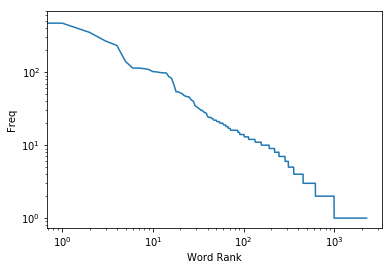

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
word_counts = sorted(Counter(words).values(), reverse=True)

plt.loglog(word_counts)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

## Generating histograms of words, screen names, and hashtags

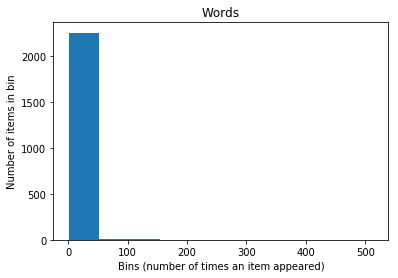

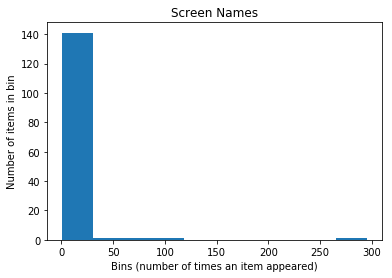

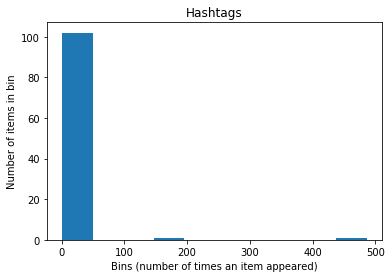

<Figure size 432x288 with 0 Axes>

In [21]:
for label, data in (('Words', words), 
                    ('Screen Names', screen_names), 
                    ('Hashtags', hashtags)):

    # Build a frequency map for each set of data
    # and plot the values
    c = Counter(data)
    plt.hist(list(c.values()))
    
    # Add a title and y-label ...
    plt.title(label)
    plt.ylabel("Number of items in bin")
    plt.xlabel("Bins (number of times an item appeared)")
    
    # ... and display as a new figure
    plt.figure()

## Generating a histogram of retweet counts

Text(0, 0.5, 'Number of tweets in bin')

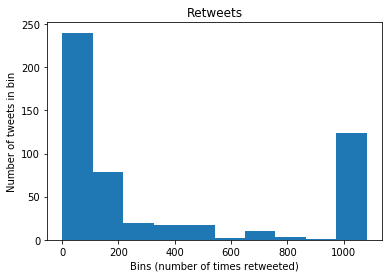

In [22]:
# Using underscores while unpacking values in
# a tuple is idiomatic for discarding them

counts = [count for count, _, _, _ in retweets]

plt.hist(counts)
plt.title('Retweets')
plt.xlabel('Bins (number of times retweeted)')
plt.ylabel('Number of tweets in bin')

## Sentiment Analysis

In [23]:
import time
import nltk
nltk.download('vader_lexicon')

import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\GAO\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [24]:
tweets = []

In [25]:
class MyStreamListener(tweepy.StreamListener):
    def __init__(self, time_limit=60):
        self.start_time = time.time()
        self.limit = time_limit
        super(MyStreamListener, self).__init__()

    def on_status(self, status):
        if (time.time() - self.start_time) < self.limit:
            if status.lang == "en":
                tweets.append(status.text)
                #print(status.text)
            return True
        else:
            return False

In [26]:
myStream = tweepy.Stream(auth=api.auth, listener=MyStreamListener(time_limit=5))
iterator = myStream.sample()

In [27]:
tweets

['RT @jackfrank_jjf: Ben Simmons says he and Joel Embiid wanna stay in Philly and win championships together https://t.co/YJDHy7Yxot',
 'RT @CIassicGaming: Mortal Kombat is the first game in the Mortal Kombat fighting game series by Midway. It was released in arcades in 1992…',
 'When arsenal wins a match, we won’t hear word 😒',
 '@mwolter14 We did not waste anything. He was the best QB on the roster at the time. That’s on Chryst, not Hornibrook.',
 'RT @artsykunkle: Congrats @khost19! \n#stolenfromfacebook https://t.co/n8V1QS7Fz1',
 '@united do the right thing and ground your fleet of #737MAX until @BoeingAirplanes figures out what is going on.',
 'RT @exol_kaa: summoning circle, and it will fucking work:\n\n                       🕯\n              🕯             🕯\n        🕯   sm station…',
 '@austincharcoal from sawdust i like romeo and juliet and from day &amp; age i like spaceman! they also have a single ca… https://t.co/BImyv2fRrF',
 '@_Fanelekile @Thabo09 Where do you buy it?',
 '

In [28]:
analyzer = SentimentIntensityAnalyzer()

In [29]:
analyzer.polarity_scores('Hello')

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [30]:
analyzer.polarity_scores('I really enjoy this video series.')

{'neg': 0.0, 'neu': 0.534, 'pos': 0.466, 'compound': 0.5413}

In [31]:
analyzer.polarity_scores('I REALLY enjoy this video series.')

{'neg': 0.0, 'neu': 0.486, 'pos': 0.514, 'compound': 0.64}

In [32]:
analyzer.polarity_scores('I REALLY enjoy this video series!!!')

{'neg': 0.0, 'neu': 0.439, 'pos': 0.561, 'compound': 0.7271}

In [33]:
analyzer.polarity_scores('I REALLY did not enjoy this video series!!!')

{'neg': 0.425, 'neu': 0.575, 'pos': 0.0, 'compound': -0.6627}

In [34]:
scores = np.zeros(len(tweets))

for i, t in enumerate(tweets):
    
    # Measure the polarity of the tweet
    polarity = analyzer.polarity_scores(t)
    
    # Store the normalized, weighted composite score
    scores[i] = polarity['compound']

In [35]:
most_positive = np.argmax(scores)
most_negative = np.argmin(scores)

In [36]:
scores

array([ 0.7906, -0.3612,  0.5719,  0.7602,  0.5707,  0.    ,  0.    ,
        0.6476,  0.    , -0.5106, -0.7964,  0.    ,  0.4404,  0.4696,
       -0.5719,  0.    ,  0.7263,  0.    ,  0.4767,  0.6996,  0.3612,
        0.    ,  0.2732,  0.    ,  0.    ,  0.3182,  0.34  ,  0.4588,
        0.4926, -0.6124, -0.296 ,  0.    ,  0.    , -0.4767, -0.5574,
       -0.34  ,  0.    ,  0.357 ,  0.    ,  0.481 ,  0.    ,  0.8271,
        0.4084,  0.    ,  0.6369,  0.    , -0.5449, -0.0258,  0.6908,
       -0.2732,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ])

In [37]:
most_positive

41

In [38]:
most_negative

10

In [39]:
print('{0:6.3f} : "{1}"'.format(scores[most_positive], tweets[most_positive]))

 0.827 : "RT @Dre_Trey5: Thank You for taking a chance on a kid from Albany,Ga and making me into who I am today . All love 🖤🙏🏾 https://t.co/rxJZpRON…"


In [40]:
print('{0:6.3f} : "{1}"'.format(scores[most_negative], tweets[most_negative]))

-0.796 : "RT @creoleasf: If I ever see her in person bro I’m staring directly at her ass. On all the gay shit. 😭 https://t.co/E6qOjvrKfb"
